In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

Text(0,0.5,'Frequency')

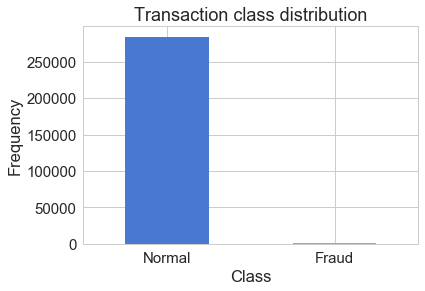

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

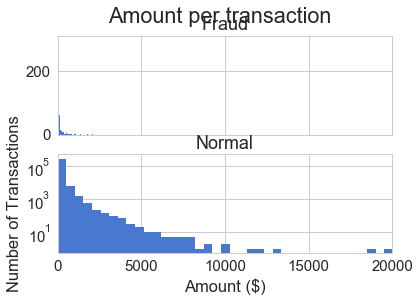

In [6]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction')

ax1.hist(frauds.Amount,bins=50)
ax1.set_title('Fraud')

ax2.hist(normal.Amount,bins=50)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')

In [7]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [9]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
'''Let’s train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a 
file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the 
training progress will be exported in a format that TensorBoard understands'''
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 16s 72us/step - loss: 0.8164 - acc: 0.5882 - val_loss: 0.7899 - val_acc: 0.6497
Epoch 2/100
227451/227451 [==============================] - 10s 43us/step - loss: 0.7475 - acc: 0.6669 - val_loss: 0.7692 - val_acc: 0.6774
Epoch 3/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7367 - acc: 0.6739 - val_loss: 0.7643 - val_acc: 0.6748
Epoch 4/100
227451/227451 [==============================] - 8s 35us/step - loss: 0.7324 - acc: 0.6728 - val_loss: 0.7621 - val_acc: 0.6672
Epoch 5/100
227451/227451 [==============================] - 10s 43us/step - loss: 0.7307 - acc: 0.6721 - val_loss: 0.7597 - val_acc: 0.6747
Epoch 6/100
227451/227451 [==============================] - 10s 43us/step - loss: 0.7287 - acc: 0.6719 - val_loss: 0.7592 - val_acc: 0.6707
Epoch 7/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7276 - acc: 0.6725 -

227451/227451 [==============================] - 8s 33us/step - loss: 0.7123 - acc: 0.6969 - val_loss: 0.7435 - val_acc: 0.7025
Epoch 59/100
 72672/227451 [========>.....................] - ETA: 4s - loss: 0.6978 - acc: 0.6959

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');